Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9


Wrote a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, November 27
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
import numpy as np
import random
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

from utils.reproduce_functions import *
from utils.mutation_functions import *
from utils.parent_selection_functions import *
from utils.other_fucntions import *
from utils.island_functions import *

import lab9_lib

In [2]:
PROBLEM_SIZE = 1

MU = 15
LAMBDA = 30
strategy = 'plus' # comma or plus

MUTATION_PROB = 0.2
DYNAMIC_MUTATION_PROB = True
DIVERSITY_THRESHOLD = 20

SEGREGATION = True
COOLDOWN_TIME = 100
LENGTH_SOLUTION = 1000
NUMBER_GENERATIONS = 5000

NUM_ISLANDS = 5

In [3]:
# Function to perform swapping between islands
mutate = one_bit_flip
reproduce = two_cuts_crossover
parent_selection = roulette

when_to_swap = fitness_based
swap_individuals_between_islands = random_swap

In [4]:
def ga(fitness, islands, islands_evals, memoization=False, history=None):
    if memoization:
        pop_history = {}
        for i in range(len(islands_evals)):
            for j in range(len(islands_evals[i])):
                pop_history[islands[i][j].tobytes()] = islands_evals[i][j]
    
    best_value = -1 
    last_change = -1
    cooldown = COOLDOWN_TIME
    for generation in tqdm(range(NUMBER_GENERATIONS)):
        for island_ix, island in enumerate(islands):
            parents = island
            parents_evals = islands_evals[island_ix]
            offsprings = []
            offsprings_evals = []

            while len(offsprings) < LAMBDA:
                
                p1, p2 = parent_selection(parents, parents_evals)
    
                # Reproduce Parents
                off_spring = reproduce(p1, p2)
                
               # Mutate Offspring
                if DYNAMIC_MUTATION_PROB:
                    p_div = get_parents_diversity(p1, p2)
                    new_ind1 = mutate(off_spring, \
                                    size=1,
                                    mutation_probability=(1 - (min(p_div,LENGTH_SOLUTION/2)/(LENGTH_SOLUTION/2))) )
                else:    
                    new_ind1 = mutate(off_spring, mutation_probability=MUTATION_PROB)

                # Evaluate Offspring
                if memoization:
                    new_ind1_eval = pop_history.get(new_ind1.tobytes())
                    if new_ind1_eval == None:
                        new_ind1_eval = fitness(new_ind1)
                        pop_history[new_ind1.tobytes()] = new_ind1_eval
                else:
                    new_ind1_eval = fitness(new_ind1)

                offsprings.append(new_ind1)

                offsprings_evals.append(new_ind1_eval)
                if memoization:
                    pop_history[new_ind1.tobytes()] = new_ind1_eval

            # Create new population (with parents if plus, without if comma)
            all_people = (parents if strategy=='plus' else []) + offsprings
            all_evals = (parents_evals if strategy=='plus' else []) + offsprings_evals
            best_people = np.argsort(all_evals)[::-1]

            parents = []
            parents_evals = []
            for i in range(MU):
                parents.append(all_people[best_people[i]])
                parents_evals.append(all_evals[best_people[i]])
            islands[island_ix] = parents
            islands_evals[island_ix] = parents_evals
            

            if history is not None:
                history[island_ix].append(np.max(all_evals))

        best_eval = max([max(x) for x in history])
        if best_eval > best_value:
            best_value = best_eval
            last_change = generation
        elif generation - last_change > COOLDOWN_TIME and len(islands) == 1:
            break

        if when_to_swap(islands_evals):
            swap_individuals_between_islands(islands)

        # if when_to_swap(generation, 10):
        #     # swap_individuals_between_islands(islands, islands_evals)
        #     swap_individuals_between_islands(islands)
        
        if history is not None and len(islands) > 1 and generation > cooldown:
            mean_fitnesses = []
            for island_ix, x in enumerate(islands_evals):
                mean_fitnesses.append(np.mean(x))

            mean_fitnesses = np.array(mean_fitnesses)
            mean_fitnesses = np.reshape(mean_fitnesses, (len(mean_fitnesses), 1))
            diff_mat = np.abs(mean_fitnesses - mean_fitnesses.transpose())

            for island_ix, island in enumerate(islands):
                if len(history[island_ix]) > COOLDOWN_TIME and \
                    (np.diff(history[island_ix])[-COOLDOWN_TIME:] == 0).all() and \
                    mean_fitnesses[island_ix] != max(mean_fitnesses):
                    
                    #print("Num islands", len(islands)-1)
                    # Merge two islands
                    most_similar_island_idx = np.argsort(diff_mat[island_ix])[1] #0 is same island, diff=0

                    islands[most_similar_island_idx].extend(islands[island_ix])
                    islands_evals[most_similar_island_idx].extend(islands_evals[island_ix])

                    if SEGREGATION == True:
                        islands.pop(island_ix)
                        islands_evals.pop(island_ix)
                    else:
                        if memoization:
                            new_island = []
                            while len(new_island) < MU:
                                new_ind = np.random.randint(2, size=LENGTH_SOLUTION)
                                if pop_history.get(new_ind.tobytes()) != None:
                                    continue
                                
                                new_island.append(new_ind)
                                pop_history[new_ind.tobytes()] = fitness(new_ind)
                                

                            islands[island_ix] = new_island
                            islands_evals[island_ix] = [pop_history[ind.tobytes()] for ind in islands[island_ix]]
                        else:
                            islands[island_ix] = [np.random.randint(2, size=LENGTH_SOLUTION) for _ in range(MU)]
                            islands_evals[island_ix] = [fitness(ind) for ind in islands[island_ix]]
                    
                    last_generation = generation
                    cooldown = generation + COOLDOWN_TIME
                    break
                    


    return parents, parents_evals

In [ ]:
def ga(fitness, islands, islands_evals, memoization=False, history=None):
    if memoization:
        pop_history = {}
        for i in range(len(islands_evals)):
            for j in range(len(islands_evals[i])):
                pop_history[islands[i][j].tobytes()] = islands_evals[i][j]
    
    best_value = -1 
    last_change = -1
    cooldown = COOLDOWN_TIME
    for generation in tqdm(range(NUMBER_GENERATIONS)):
        for island_ix, island in enumerate(islands):
            parents = island
            parents_evals = islands_evals[island_ix]
            offsprings = []
            offsprings_evals = []

            while len(offsprings) < LAMBDA:
                
                p1, p2 = parent_selection(parents, parents_evals)
    
                # Reproduce Parents
                off_spring = reproduce(p1, p2)
                
               # Mutate Offspring
                if DYNAMIC_MUTATION_PROB:
                    p_div = get_parents_diversity(p1, p2)
                    new_ind1 = mutate(off_spring, \
                                    size=1,
                                    mutation_probability=(1 - (min(p_div,LENGTH_SOLUTION/2)/(LENGTH_SOLUTION/2))) )
                else:    
                    new_ind1 = mutate(off_spring, mutation_probability=MUTATION_PROB)

                # Evaluate Offspring
                if memoization:
                    new_ind1_eval = pop_history.get(new_ind1.tobytes())
                    if new_ind1_eval == None:
                        new_ind1_eval = fitness(new_ind1)
                        pop_history[new_ind1.tobytes()] = new_ind1_eval
                else:
                    new_ind1_eval = fitness(new_ind1)

                offsprings.append(new_ind1)

                offsprings_evals.append(new_ind1_eval)
                if memoization:
                    pop_history[new_ind1.tobytes()] = new_ind1_eval

            # Create new population (with parents if plus, without if comma)
            all_people = (parents if strategy=='plus' else []) + offsprings
            all_evals = (parents_evals if strategy=='plus' else []) + offsprings_evals
            best_people = np.argsort(all_evals)[::-1]

            parents = []
            parents_evals = []
            for i in range(MU):
                parents.append(all_people[best_people[i]])
                parents_evals.append(all_evals[best_people[i]])
            islands[island_ix] = parents
            islands_evals[island_ix] = parents_evals
            

            if history is not None:
                history[island_ix].append(np.max(all_evals))

        best_eval = max([max(x) for x in history])
        if best_eval > best_value:
            best_value = best_eval
            last_change = generation
        elif generation - last_change > COOLDOWN_TIME and len(islands) == 1:
            break

        if when_to_swap(islands_evals):
            swap_individuals_between_islands(islands)

        # if when_to_swap(generation, 10):
        #     # swap_individuals_between_islands(islands, islands_evals)
        #     swap_individuals_between_islands(islands)
        
        if history is not None and len(islands) > 1 and generation > cooldown:
            mean_fitnesses = []
            for island_ix, x in enumerate(islands_evals):
                mean_fitnesses.append(np.mean(x))

            mean_fitnesses = np.array(mean_fitnesses)
            mean_fitnesses = np.reshape(mean_fitnesses, (len(mean_fitnesses), 1))
            diff_mat = np.abs(mean_fitnesses - mean_fitnesses.transpose())

            for island_ix, island in enumerate(islands):
                if len(history[island_ix]) > COOLDOWN_TIME and \
                    (np.diff(history[island_ix])[-COOLDOWN_TIME:] == 0).all() and \
                    mean_fitnesses[island_ix] != max(mean_fitnesses):
                    
                    #print("Num islands", len(islands)-1)
                    # Merge two islands
                    most_similar_island_idx = np.argsort(diff_mat[island_ix])[1] #0 is same island, diff=0

                    islands[most_similar_island_idx].extend(islands[island_ix])
                    islands_evals[most_similar_island_idx].extend(islands_evals[island_ix])

                    if SEGREGATION == True:
                        islands.pop(island_ix)
                        islands_evals.pop(island_ix)
                    else:
                        if memoization:
                            new_island = []
                            while len(new_island) < MU:
                                new_ind = np.random.randint(2, size=LENGTH_SOLUTION)
                                if pop_history.get(new_ind.tobytes()) != None:
                                    continue
                                
                                new_island.append(new_ind)
                                pop_history[new_ind.tobytes()] = fitness(new_ind)
                                

                            islands[island_ix] = new_island
                            islands_evals[island_ix] = [pop_history[ind.tobytes()] for ind in islands[island_ix]]
                        else:
                            islands[island_ix] = [np.random.randint(2, size=LENGTH_SOLUTION) for _ in range(MU)]
                            islands_evals[island_ix] = [fitness(ind) for ind in islands[island_ix]]
                    
                    last_generation = generation
                    cooldown = generation + COOLDOWN_TIME
                    break
                    


    return parents, parents_evals

Without memoization

In [5]:
# fitness = lab9_lib.make_problem(PROBLEM_SIZE)
# islands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]
# history = [[] for _ in range(NUM_ISLANDS)]

# islands_evals = [[fitness(x) for x in island] for island in islands ]
# parents, parents_evals = ga(fitness, islands, islands_evals, memoization=False, history=history)
# i_best = np.argmax(parents_evals)

# print("Best score: ", max([max(x) for x in history]))
# print("Num fitness calls: ", fitness.calls)

# for x in history:
#     plt.plot(x)
# plt.show()

With memoization

  0%|          | 3/5000 [00:00<04:16, 19.51it/s]

 10%|█         | 503/5000 [00:21<03:10, 23.64it/s]


Best score:  1.0
Num fitness calls:  22518


100%|██████████| 5000/5000 [05:41<00:00, 14.66it/s]


Best score:  1.0
Num fitness calls:  23041


100%|██████████| 5000/5000 [05:22<00:00, 15.52it/s]


Best score:  1.0
Num fitness calls:  25926


100%|██████████| 5000/5000 [04:26<00:00, 18.79it/s]


Best score:  1.0
Num fitness calls:  25414


100%|██████████| 5000/5000 [04:32<00:00, 18.33it/s]


Best score:  1.0
Num fitness calls:  24462


100%|██████████| 5000/5000 [04:10<00:00, 19.93it/s]


Best score:  1.0
Num fitness calls:  23848


100%|██████████| 5000/5000 [03:52<00:00, 21.49it/s]


Best score:  1.0
Num fitness calls:  20137


100%|██████████| 5000/5000 [03:39<00:00, 22.78it/s]


Best score:  1.0
Num fitness calls:  23008


100%|██████████| 5000/5000 [03:28<00:00, 23.95it/s]


Best score:  1.0
Num fitness calls:  22130


100%|██████████| 5000/5000 [03:24<00:00, 24.50it/s]


Best score:  1.0
Num fitness calls:  24434


 10%|█         | 508/5000 [00:15<02:15, 33.19it/s]


Best score:  1.0
Num fitness calls:  19196


100%|██████████| 5000/5000 [02:54<00:00, 28.58it/s]


Best score:  1.0
Num fitness calls:  26018


 10%|█         | 524/5000 [00:15<02:16, 32.76it/s]


Best score:  1.0
Num fitness calls:  25964


100%|██████████| 5000/5000 [03:16<00:00, 25.46it/s]


Best score:  1.0
Num fitness calls:  20785


100%|██████████| 5000/5000 [03:06<00:00, 26.75it/s]


Best score:  1.0
Num fitness calls:  22603


100%|██████████| 5000/5000 [03:17<00:00, 25.35it/s]


Best score:  1.0
Num fitness calls:  25335


100%|██████████| 5000/5000 [03:24<00:00, 24.40it/s]


Best score:  1.0
Num fitness calls:  21789


100%|██████████| 5000/5000 [02:54<00:00, 28.66it/s]


Best score:  1.0
Num fitness calls:  19232


100%|██████████| 5000/5000 [03:15<00:00, 25.60it/s]


Best score:  1.0
Num fitness calls:  22414


100%|██████████| 5000/5000 [02:31<00:00, 32.99it/s]


Best score:  1.0
Num fitness calls:  22464


100%|██████████| 5000/5000 [02:41<00:00, 30.94it/s]


Best score:  1.0
Num fitness calls:  21831


 10%|█         | 505/5000 [00:14<02:06, 35.65it/s]


Best score:  1.0
Num fitness calls:  23414


100%|██████████| 5000/5000 [02:40<00:00, 31.13it/s]


Best score:  1.0
Num fitness calls:  21485


100%|██████████| 5000/5000 [02:40<00:00, 31.18it/s]


Best score:  1.0
Num fitness calls:  23137


100%|██████████| 5000/5000 [02:40<00:00, 31.24it/s]


Best score:  1.0
Num fitness calls:  20650


100%|██████████| 5000/5000 [02:09<00:00, 38.58it/s]


Best score:  1.0
Num fitness calls:  18979


100%|██████████| 5000/5000 [02:40<00:00, 31.24it/s]


Best score:  1.0
Num fitness calls:  25081


100%|██████████| 5000/5000 [02:40<00:00, 31.08it/s]


Best score:  1.0
Num fitness calls:  21449


100%|██████████| 5000/5000 [02:09<00:00, 38.53it/s]


Best score:  1.0
Num fitness calls:  28044


100%|██████████| 5000/5000 [02:27<00:00, 33.79it/s]


Best score:  1.0
Num fitness calls:  23462
1.0
22941.666666666668


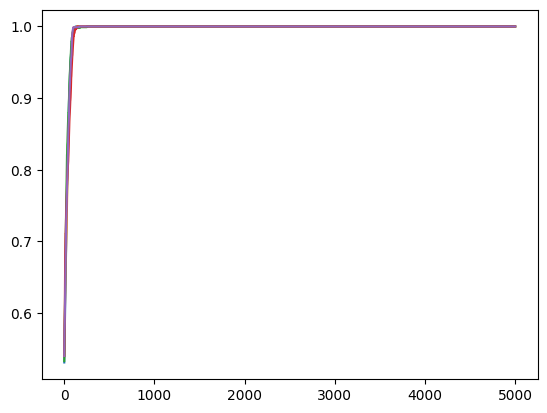

In [6]:
fitnesses = []
calls = []
for _ in range(30):
    fitness = lab9_lib.make_problem(PROBLEM_SIZE)
    islands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]
    islands_evals = [[fitness(x) for x in island] for island in islands ]

    history = [[] for _ in range(NUM_ISLANDS)]

    parents, parents_evals = ga(fitness, islands, islands_evals, memoization=True, history=history)
    i_best = np.argmax(parents_evals)

    fitnesses.append(max([max(x) for x in history]))
    calls.append(fitness.calls)
    print("Best score: ", max([max(x) for x in history]))
    print("Num fitness calls: ", fitness.calls)
    
print("="*40)
print(np.mean(fitnesses))
print(np.mean(calls))
for x in history:
    plt.plot(x)
plt.show()

In [7]:
print(fitnesses)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
